#### 3. - MODELADO DE CLASIFICACIÓN DE EMISIONES GEI

- Objetivo: Entrenar y evaluar 4 modelos de clasificación para predecir 
  el nivel de impacto ambiental de sectores NAICS.

- Modelos:
    1. Logistic Regression (con scaling)
    2. K-Nearest Neighbors (con scaling)
    3. Decision Tree (sin scaling)
    4. Random Forest (sin scaling)

#### 3.0 Imports

In [1]:
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from src.modeling import (
    prepare_data,
    encode_categorical_features,
    scale_features,
    train_logistic_regression,
    train_knn,
    train_decision_tree,
    train_random_forest,
    evaluate_model,
    compare_models,
    plot_confusion_matrices,
    plot_metrics_comparison,
    get_feature_importance,
    plot_feature_importance,
    save_model
)
from src import modeling

importlib.reload(modeling)
warnings.filterwarnings('ignore')
sys.path.append('../src')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


#### 3.1 Cargar Dataset

In [2]:
df = pd.read_csv('datos/dataset_for_modeling.csv')

print("="*70)
print("📊 DATASET CARGADO")
print("="*70)
print(f"\n🔢 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"\n📋 Columnas:")
print(df.columns.tolist())
print(f"\n🎯 Distribución de clases:")
print(df['impact_class'].value_counts().sort_index())
print(f"\n👀 Primeras 5 filas:")
df.head()

📊 DATASET CARGADO

🔢 Dimensiones: 1016 filas × 16 columnas

📋 Columnas:
['naics_code', 'naics_title', 'naics_2dig', 'sef_mef_ratio', 'co2_emission', 'ch4_emission', 'n2o_emission', 'hfcs_emission', 'pfcs_emission', 'sf6_emission', 'nf3_emission', 'hfc_pfc_unspecified', 'num_gases_emitted', 'gas_diversity', 'dominant_gas', 'impact_class']

🎯 Distribución de clases:
impact_class
0    277
1    233
2    252
3    254
Name: count, dtype: int64

👀 Primeras 5 filas:


,naics_code,naics_title,naics_2dig,sef_mef_ratio,co2_emission,ch4_emission,n2o_emission,hfcs_emission,pfcs_emission,sf6_emission,nf3_emission,hfc_pfc_unspecified,num_gases_emitted,gas_diversity,dominant_gas,impact_class
0,111110,Soybean Farming,11,11.090909,0.172,0.013496,0.34450,0.000823,0.000143,0.000105,0.000023,0.000844,3,0.753590,n2o,3
1,111120,Oilseed (except Soybean) Farming,11,11.090909,0.172,0.013496,0.34450,0.000823,0.000143,0.000105,0.000023,0.000844,3,0.753590,n2o,3
2,111130,Dry Pea and Bean Farming,11,20.225000,0.207,0.111440,0.52735,0.000794,0.000148,0.000104,0.000023,0.000802,3,0.915637,n2o,3
3,111140,Wheat Farming,11,20.225000,0.207,0.111440,0.52735,0.000794,0.000148,0.000104,0.000023,0.000802,3,0.915637,n2o,3
4,111150,Corn Farming,11,20.225000,0.207,0.111440,0.52735,0.000794,0.000148,0.000104,0.000023,0.000802,3,0.915637,n2o,3


#### 3.2 Preparación de Datos - Split

In [3]:
# Split estratificado 75/25
X_train, X_test, y_train, y_test, numeric_features, categorical_features = prepare_data(
    df=df,
    target_col='impact_class',
    test_size=0.25,
    random_state=42
)

📊 PREPARACIÓN DE DATOS COMPLETADA

🔢 Dimensiones:
   Train set: 762 filas × 13 features
   Test set:  254 filas × 13 features

📋 Features:
   Numéricas: 12
   Categóricas: 1

🎯 Distribución del target:
   Train:
impact_class
0    208
1    175
2    189
3    190
Name: count, dtype: int64
   Test:
impact_class
0    69
1    58
2    63
3    64
Name: count, dtype: int64


#### 3.3 Preparación de Datos - Encoding

In [4]:
# Codificar features categóricas
X_train_encoded, X_test_encoded, encoders = encode_categorical_features(
    X_train=X_train,
    X_test=X_test,
    categorical_features=categorical_features
)

print(f"\n📝 Encoders guardados:")
for col, encoder in encoders.items():
    print(f"   {col}: {len(encoder.classes_)} clases")


✅ Features categóricas codificadas: ['dominant_gas']

📝 Encoders guardados:
   dominant_gas: 3 clases


#### 3.4 Preparación de Datos - Scaling

In [5]:
# Escalar features numéricas (para Logistic Regression y KNN)
X_train_scaled, X_test_scaled, scaler = scale_features(
    X_train=X_train_encoded,
    X_test=X_test_encoded,
    numeric_features=numeric_features
)

print(f"\n📊 Estadísticas después del scaling (primeras 3 features):")
print(X_train_scaled[numeric_features[:3]].describe().loc[['mean', 'std']])


✅ Features numéricas escaladas: 12 features

📊 Estadísticas después del scaling (primeras 3 features):
        naics_2dig  sef_mef_ratio  co2_emission
mean  6.061060e-17   9.324708e-18 -6.643854e-17
std   1.000657e+00   1.000657e+00  1.000657e+00


### 3.5 Modelo: Logistic Regression

#### Entrenar Logistic Regression

In [6]:
# Entrenar Logistic Regression
lr_model = train_logistic_regression(
    X_train=X_train_scaled,
    y_train=y_train,
    max_iter=1000,
    random_state=42
)


✅ Logistic Regression entrenado


#### Evaluar Logistic Regression

In [7]:
# Evaluar Logistic Regression
lr_metrics = evaluate_model(
    model=lr_model,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name='Logistic Regression'
)


📊 RESULTADOS - Logistic Regression
   Accuracy:  0.8937
   Precision: 0.8930
   Recall:    0.8937
   F1-Score:  0.8930
   AUC-ROC:   0.9749

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        69
           1       0.79      0.78      0.78        58
           2       0.88      0.84      0.86        63
           3       0.98      0.98      0.98        64

    accuracy                           0.89       254
   macro avg       0.89      0.89      0.89       254
weighted avg       0.89      0.89      0.89       254



### 3.6 Modelo: K-Nearest Neighbors

#### Entrenar K-Nearest Neighbors

In [8]:
# Entrenar KNN
knn_model = train_knn(
    X_train=X_train_scaled,
    y_train=y_train,
    n_neighbors=5
)


✅ KNN entrenado (k=5)


#### Evaluar K-Nearest Neighbors

In [9]:
# Evaluar KNN
knn_metrics = evaluate_model(
    model=knn_model,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name='K-Nearest Neighbors'
)


📊 RESULTADOS - K-Nearest Neighbors
   Accuracy:  0.8819
   Precision: 0.8857
   Recall:    0.8819
   F1-Score:  0.8831
   AUC-ROC:   0.9770

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92        69
           1       0.76      0.83      0.79        58
           2       0.86      0.86      0.86        63
           3       0.95      0.95      0.95        64

    accuracy                           0.88       254
   macro avg       0.88      0.88      0.88       254
weighted avg       0.89      0.88      0.88       254



### 3.7 Modelo: Decision Tree

#### Entrenar Decision Tree

In [10]:
dt_model = train_decision_tree(
    X_train=X_train_encoded,
    y_train=y_train,
    max_depth=10,
    min_samples_split=20,
    random_state=42
)


✅ Decision Tree entrenado (max_depth=10)


#### Evaluar Decision Tree

In [11]:
dt_metrics = evaluate_model(
    model=dt_model,
    X_test=X_test_encoded,
    y_test=y_test,
    model_name='Decision Tree'
)


📊 RESULTADOS - Decision Tree
   Accuracy:  0.9803
   Precision: 0.9807
   Recall:    0.9803
   F1-Score:  0.9802
   AUC-ROC:   0.9943

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       0.95      1.00      0.97        58
           2       0.98      0.94      0.96        63
           3       0.98      0.98      0.98        64

    accuracy                           0.98       254
   macro avg       0.98      0.98      0.98       254
weighted avg       0.98      0.98      0.98       254



### 3.8 Modelo: Random Forest

#### Entrenar Random Forest

In [12]:
rf_model = train_random_forest(
    X_train=X_train_encoded,
    y_train=y_train,
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    random_state=42
)


✅ Random Forest entrenado (n_estimators=100)


#### Evaluar Random Forest

In [13]:
rf_metrics = evaluate_model(
    model=rf_model,
    X_test=X_test_encoded,
    y_test=y_test,
    model_name='Random Forest'
)


📊 RESULTADOS - Random Forest
   Accuracy:  0.9882
   Precision: 0.9885
   Recall:    0.9882
   F1-Score:  0.9881
   AUC-ROC:   0.9998

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       0.97      1.00      0.98        58
           2       1.00      0.95      0.98        63
           3       0.98      1.00      0.99        64

    accuracy                           0.99       254
   macro avg       0.99      0.99      0.99       254
weighted avg       0.99      0.99      0.99       254



#### 3.9 Comparar Modelos - Tabla

In [14]:
# Lista de métricas de todos los modelos
all_metrics = [lr_metrics, knn_metrics, dt_metrics, rf_metrics]

# Comparar modelos
comparison_df = compare_models(all_metrics)


🏆 COMPARACIÓN DE MODELOS
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
      Random Forest  0.988189   0.988512 0.988189  0.988127 0.999795
      Decision Tree  0.980315   0.980699 0.980315  0.980224 0.994315
Logistic Regression  0.893701   0.893004 0.893701  0.893011 0.974853
K-Nearest Neighbors  0.881890   0.885654 0.881890  0.883109 0.977028


#### 3.10 Comparar Modelos - Gráfico de Métricas

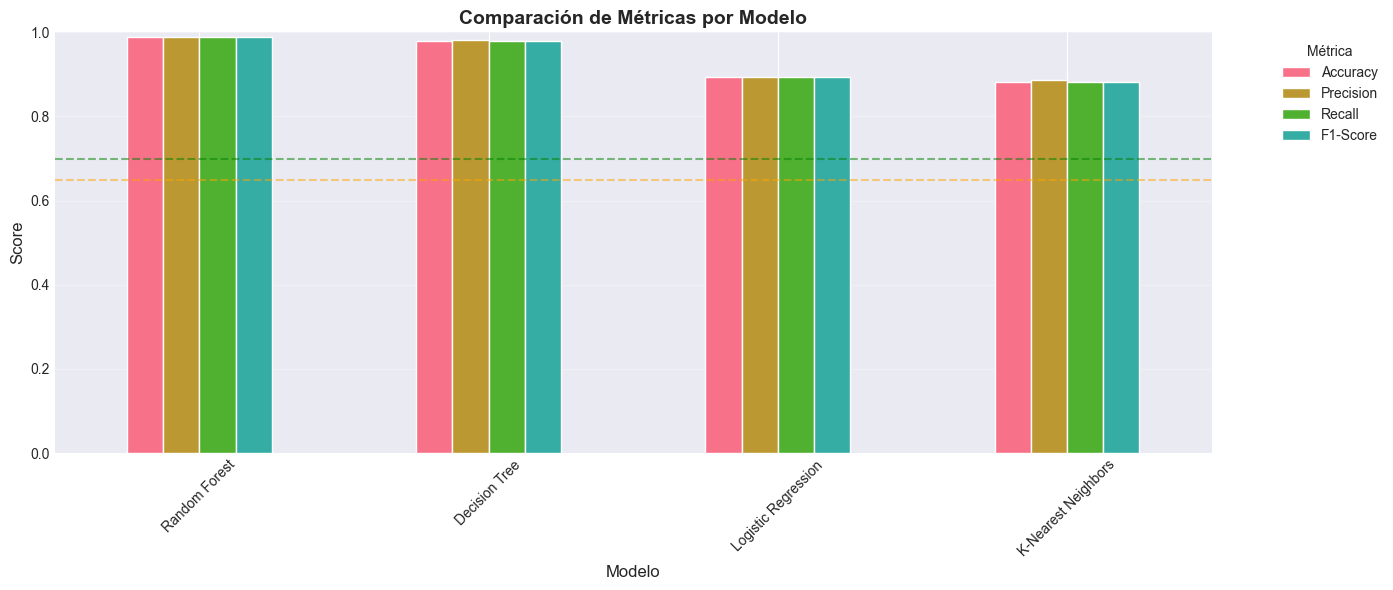

In [15]:
# Visualizar comparación de métricas
plot_metrics_comparison(comparison_df, figsize=(14, 6))

#### 3.11 Comparar Modelos - Matrices de Confusión

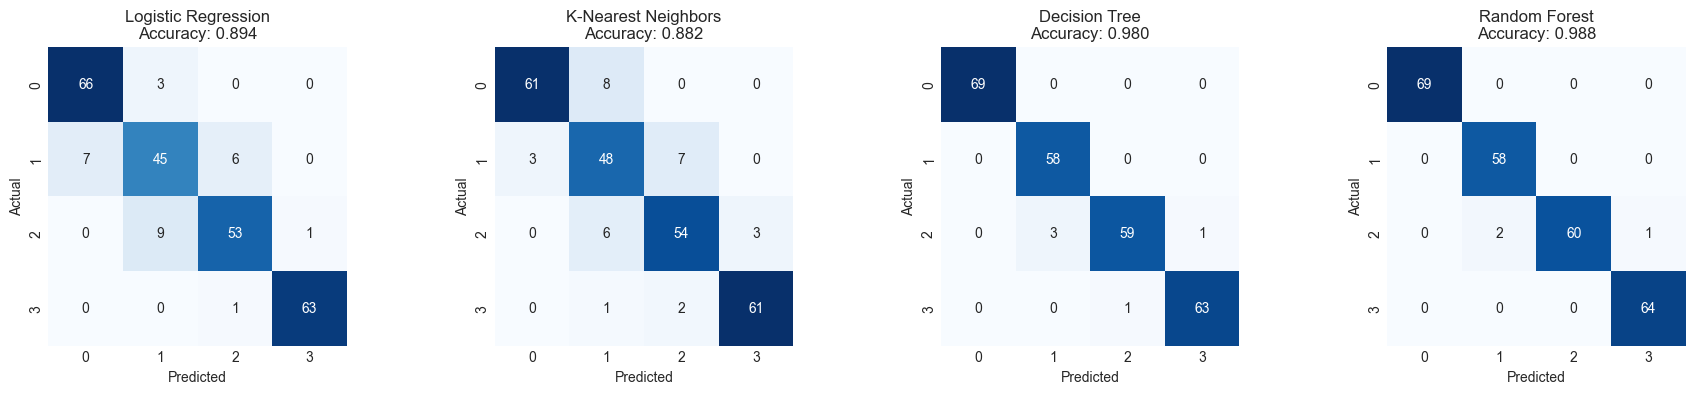

In [16]:
# Visualizar matrices de confusión
plot_confusion_matrices(all_metrics, figsize=(18, 4))



#### 3.12 Feature Importance - Random Forest

In [17]:
# Obtener nombres de features
feature_names = X_train_encoded.columns.tolist()

# Feature importance para Random Forest
rf_importance = get_feature_importance(
    model=rf_model,
    feature_names=feature_names,
    top_n=15
)


🎯 TOP 15 FEATURES MÁS IMPORTANTES
            feature  importance
       co2_emission    0.322451
       ch4_emission    0.179071
      sef_mef_ratio    0.120875
       n2o_emission    0.107061
         naics_2dig    0.074329
       sf6_emission    0.058464
      gas_diversity    0.053983
      hfcs_emission    0.020530
      pfcs_emission    0.018860
hfc_pfc_unspecified    0.016880
       nf3_emission    0.016588
  num_gases_emitted    0.005517
       dominant_gas    0.005391


#### 3.13 Visualizar Feature Importance - Random Forest

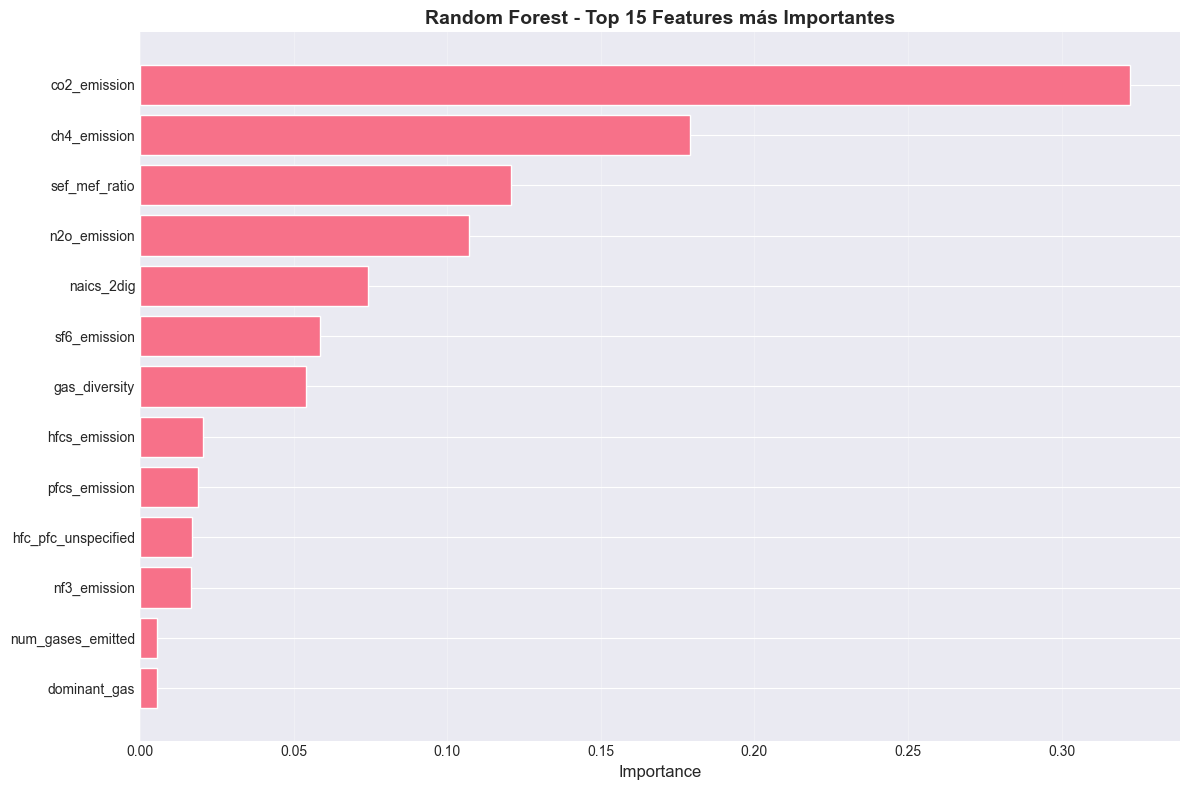

In [18]:
# Visualizar feature importance
if rf_importance is not None:
    plot_feature_importance(
        importance_df=rf_importance,
        title='Random Forest - Top 15 Features más Importantes',
        figsize=(12, 8)
    )

#### 3.14 Feature Importance - Decision Tree

In [19]:
# Feature importance para Decision Tree
dt_importance = get_feature_importance(
    model=dt_model,
    feature_names=feature_names,
    top_n=15
)


🎯 TOP 15 FEATURES MÁS IMPORTANTES
            feature  importance
       co2_emission    0.602544
       ch4_emission    0.146935
      sef_mef_ratio    0.093528
       n2o_emission    0.054966
       dominant_gas    0.039284
         naics_2dig    0.031613
      gas_diversity    0.021843
       nf3_emission    0.003507
      hfcs_emission    0.003472
       sf6_emission    0.002309
      pfcs_emission    0.000000
  num_gases_emitted    0.000000
hfc_pfc_unspecified    0.000000


#### 3.15 Visualizar Feature Importance - Decision Tree

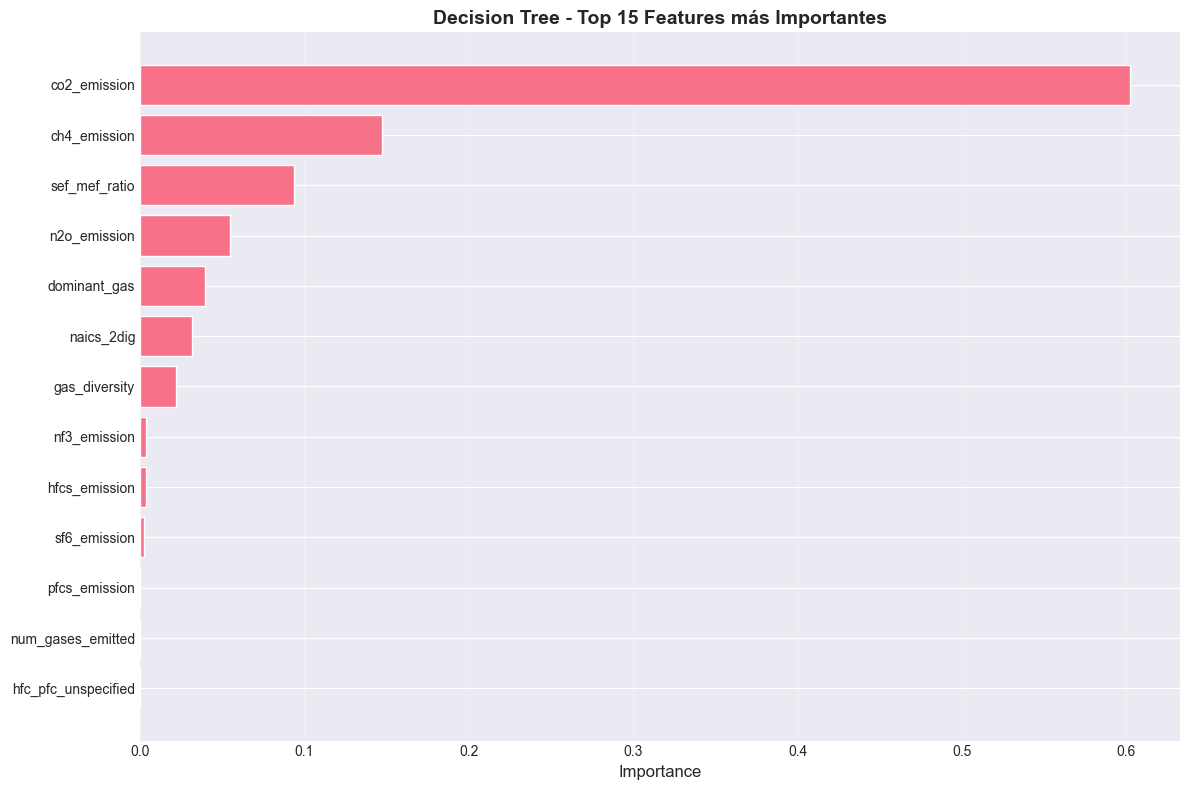

In [20]:
# Visualizar feature importance
if dt_importance is not None:
    plot_feature_importance(
        importance_df=dt_importance,
        title='Decision Tree - Top 15 Features más Importantes',
        figsize=(12, 8)
    )

#### 3.16 Identificar Mejor Modelo

#### Identificar mejor modelo por F1-Score

In [21]:
best_model_row = comparison_df.loc[comparison_df['F1-Score'].idxmax()]
best_model_name = best_model_row['Model']

print("\n" + "="*70)
print("🏆 MEJOR MODELO")
print("="*70)
print(f"\n🥇 Modelo seleccionado: {best_model_name}")
print(f"\n📊 Métricas:")
print(f"   Accuracy:  {best_model_row['Accuracy']:.4f}")
print(f"   Precision: {best_model_row['Precision']:.4f}")
print(f"   Recall:    {best_model_row['Recall']:.4f}")
print(f"   F1-Score:  {best_model_row['F1-Score']:.4f}")
if not pd.isna(best_model_row['AUC-ROC']):
    print(f"   AUC-ROC:   {best_model_row['AUC-ROC']:.4f}")


🏆 MEJOR MODELO

🥇 Modelo seleccionado: Random Forest

📊 Métricas:
   Accuracy:  0.9882
   Precision: 0.9885
   Recall:    0.9882
   F1-Score:  0.9881
   AUC-ROC:   0.9998


#### Identificar el objeto del modelo

In [22]:
models_dict = {
    'Logistic Regression': lr_model,
    'K-Nearest Neighbors': knn_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model
}

best_model = models_dict[best_model_name]
print(f"\n✅ Modelo identificado para guardar")


✅ Modelo identificado para guardar


#### 3.17 Guardar Mejor Modelo

In [24]:
# Crear carpeta si no existe
import os
os.makedirs('../modelos', exist_ok=True)

# Guardar mejor modelo
save_model(best_model, '../modelos/best_model.pkl')


✅ Modelo guardado en: ../models/best_model.pkl


#### 3.18 Guardar Scaler (si aplica)

In [25]:
# Guardar scaler (si el mejor modelo lo requiere)
if best_model_name in ['Logistic Regression', 'K-Nearest Neighbors']:
    save_model(scaler, '../modelos/scaler.pkl')
    print("✅ Scaler también guardado")
else:
    print("ℹ️ El mejor modelo no requiere scaler")

ℹ️ El mejor modelo no requiere scaler


#### 3.20 Guardar Encoders

In [27]:
# Guardar encoders
save_model(encoders, '../modelos/encoders.pkl')
print("✅ Encoders guardados")


✅ Modelo guardado en: ../models/encoders.pkl
✅ Encoders guardados


#### 3.21 Guardar Comparación de Modelos

In [28]:
# Guardar comparación de modelos
comparison_df.to_csv('../modelos/model_comparison.csv', index=False)
print("\n✅ Comparación de modelos guardada en: ../modelos/model_comparison.csv")


✅ Comparación de modelos guardada en: ../models/model_comparison.csv


#### 3.22 Guardar Feature Importance (si aplica)

In [30]:
# Guardar feature importance del mejor modelo
if best_model_name in ['Random Forest', 'Decision Tree']:
    best_importance = get_feature_importance(
        model=best_model,
        feature_names=feature_names,
        top_n=len(feature_names)
    )
    best_importance.to_csv('../modelos/feature_importance.csv', index=False)
    print("✅ Feature importance guardado en: ../modelos/feature_importance.csv")
else:
    print("ℹ️ El mejor modelo no tiene feature importance")


🎯 TOP 13 FEATURES MÁS IMPORTANTES
            feature  importance
       co2_emission    0.322451
       ch4_emission    0.179071
      sef_mef_ratio    0.120875
       n2o_emission    0.107061
         naics_2dig    0.074329
       sf6_emission    0.058464
      gas_diversity    0.053983
      hfcs_emission    0.020530
      pfcs_emission    0.018860
hfc_pfc_unspecified    0.016880
       nf3_emission    0.016588
  num_gases_emitted    0.005517
       dominant_gas    0.005391
✅ Feature importance guardado en: ../models/feature_importance.csv


#### 3.23 Resumen Final

In [31]:
print("\n" + "="*70)
print("📋 RESUMEN DEL MODELADO")
print("="*70)

print(f"\n📊 Dataset:")
print(f"   Total de observaciones: {len(df)}")
print(f"   Train set: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"   Test set: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")
print(f"   Features: {len(feature_names)}")
print(f"   Clases: {len(y_train.unique())}")

print(f"\n🤖 Modelos entrenados:")
for model_name in comparison_df['Model']:
    f1 = comparison_df[comparison_df['Model']==model_name]['F1-Score'].values[0]
    emoji = "🏆" if model_name == best_model_name else "  "
    print(f"   {emoji} {model_name}: F1-Score = {f1:.4f}")

print(f"\n🎯 Cumplimiento de objetivos:")
best_accuracy = best_model_row['Accuracy']
best_f1 = best_model_row['F1-Score']

accuracy_goal = "✅ SÍ" if best_accuracy >= 0.70 else "❌ NO"
f1_goal = "✅ SÍ" if best_f1 >= 0.65 else "❌ NO"

print(f"   Accuracy ≥ 0.70: {accuracy_goal} (alcanzado: {best_accuracy:.4f})")
print(f"   F1-Score ≥ 0.65: {f1_goal} (alcanzado: {best_f1:.4f})")

print(f"\n💾 Archivos generados:")
print(f"   ../modelos/best_model.pkl")
if best_model_name in ['Logistic Regression', 'K-Nearest Neighbors']:
    print(f"   ../modelos/scaler.pkl")
print(f"   ../modelos/encoders.pkl")
print(f"   ../modelos/model_comparison.csv")
if best_model_name in ['Random Forest', 'Decision Tree']:
    print(f"   ../modelos/feature_importance.csv")

print("\n" + "="*70)
print("✅ MODELADO COMPLETADO")
print("="*70)


📋 RESUMEN DEL MODELADO

📊 Dataset:
   Total de observaciones: 1016
   Train set: 762 (75.0%)
   Test set: 254 (25.0%)
   Features: 13
   Clases: 4

🤖 Modelos entrenados:
   🏆 Random Forest: F1-Score = 0.9881
      Decision Tree: F1-Score = 0.9802
      Logistic Regression: F1-Score = 0.8930
      K-Nearest Neighbors: F1-Score = 0.8831

🎯 Cumplimiento de objetivos:
   Accuracy ≥ 0.70: ✅ SÍ (alcanzado: 0.9882)
   F1-Score ≥ 0.65: ✅ SÍ (alcanzado: 0.9881)

💾 Archivos generados:
   ../modelos/best_model.pkl
   ../modelos/encoders.pkl
   ../modelos/model_comparison.csv
   ../modelos/feature_importance.csv

✅ MODELADO COMPLETADO


📝 PARA TU DOCUMENTACIÓN
Mensaje clave:

"El modelo Random Forest alcanzó 98.81% F1-Score usando principalmente emisiones de CO₂ (32%), CH₄ (18%), el ratio estructura económica (12%) y N₂O (11%). Esta combinación de variables químicas y económicas captura la firma única de cada sector industrial, permitiendo clasificar su impacto ambiental con alta precisión."